In [1]:
import os

os.chdir("../..")

In [ ]:
import os
import re
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
from tensorboard.plugins.hparams.plugin_data_pb2 import HParamsPluginData
from tensorboard.plugins.hparams import api_pb2


# -------- Utilities to find event files --------
def find_event_files(root: Path):
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.startswith("events.out.tfevents"):
                yield Path(dirpath) / fn


# -------- Read HParams from an event file --------
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
from tensorboard.plugins.hparams.plugin_data_pb2 import HParamsPluginData


def parse_hparams_from_eventfile(event_file):
    """Extract a dict of hparams from a TensorBoard tfevents file."""

    def _coerce_value(v):
        kind = v.WhichOneof("kind")
        if kind == "number_value":
            num = v.number_value
            return int(num) if float(num).is_integer() else float(num)
        if kind == "string_value":
            return v.string_value
        if kind == "bool_value":
            return bool(v.bool_value)
        return None

    hparams = {}
    type_map = {}  # optional: name -> enum type
    loader = EventFileLoader(str(event_file))

    for event in loader.Load():
        if not getattr(event, "summary", None) or not event.summary.value:
            continue

        for v in event.summary.value:
            pd = getattr(v.metadata, "plugin_data", None)
            if not pd or pd.plugin_name != "hparams":
                continue

            data = HParamsPluginData()
            data.ParseFromString(pd.content)

            # Optional: collect declared types.
            if data.HasField("experiment"):
                for info in data.experiment.hparam_infos:
                    type_map[info.name] = info.type

            # Main: read values from session_start_info.hparams
            if data.HasField("session_start_info"):
                hp_map = data.session_start_info.hparams

                # In recent TB protos this is a map<string, Value> → use .items().
                # In older shapes it can be a repeated list with .key/.value.
                items = getattr(hp_map, "items", None)
                if callable(items):
                    iterator = hp_map.items()  # (key, Value)
                else:
                    iterator = ((kv.key, kv.value) for kv in hp_map)

                for key, val in iterator:
                    py_val = _coerce_value(val)
                    if py_val is not None:
                        hparams[key] = py_val

    return hparams


def load_scalars(run_dir: Path, tags_of_interest=None):
    """
    Reads all scalar tags (or a subset) and returns dict[tag] -> (steps, values)
    """
    ea = EventAccumulator(str(run_dir), size_guidance={"scalars": 10_000})
    ea.Reload()

    have = set(ea.Tags().get("scalars", []))
    tags = (tags_of_interest or have) & have if tags_of_interest else have

    out = {}
    for tag in sorted(tags):
        series = ea.Scalars(tag)
        steps = [s.step for s in series]
        vals = [s.value for s in series]
        out[tag] = (steps, vals)
    return out


# legend text from hparams
def format_hparams(
    hparams: dict,
    keys=(
        "d_model",
        "nhead",
        "tokenizer_bins",
        "lr",
        "use_padding_mask",
        "n_layers",
        "num_layers",
        "tokenizer_class",
        "tokenizer",
    ),
):
    items = []
    for k in keys:
        if k in hparams:
            v = hparams[k]
            if isinstance(v, float):
                v_str = f"{v:g}" if abs(v) >= 1e-2 else f"{v:.2e}"
            else:
                v_str = str(v)
            items.append(f"{k}={v_str}")
    return ", ".join(items) if items else None

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one "run metadata" event with tag step1. Overwriting it with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one "run metadata" event with tag step1. Overwriting it with the newest event.
C:\Users\matth\AppData\Local\Temp\ipykernel_30504\2770400901.py:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[0, 0, 0.8, 1])


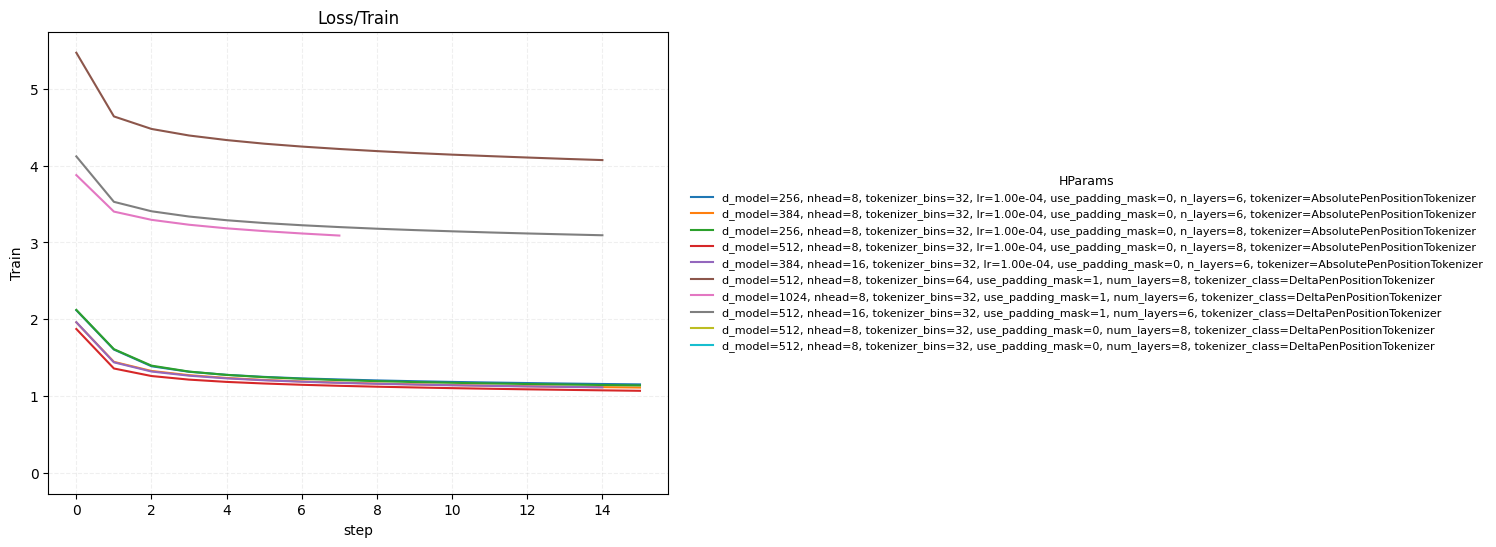

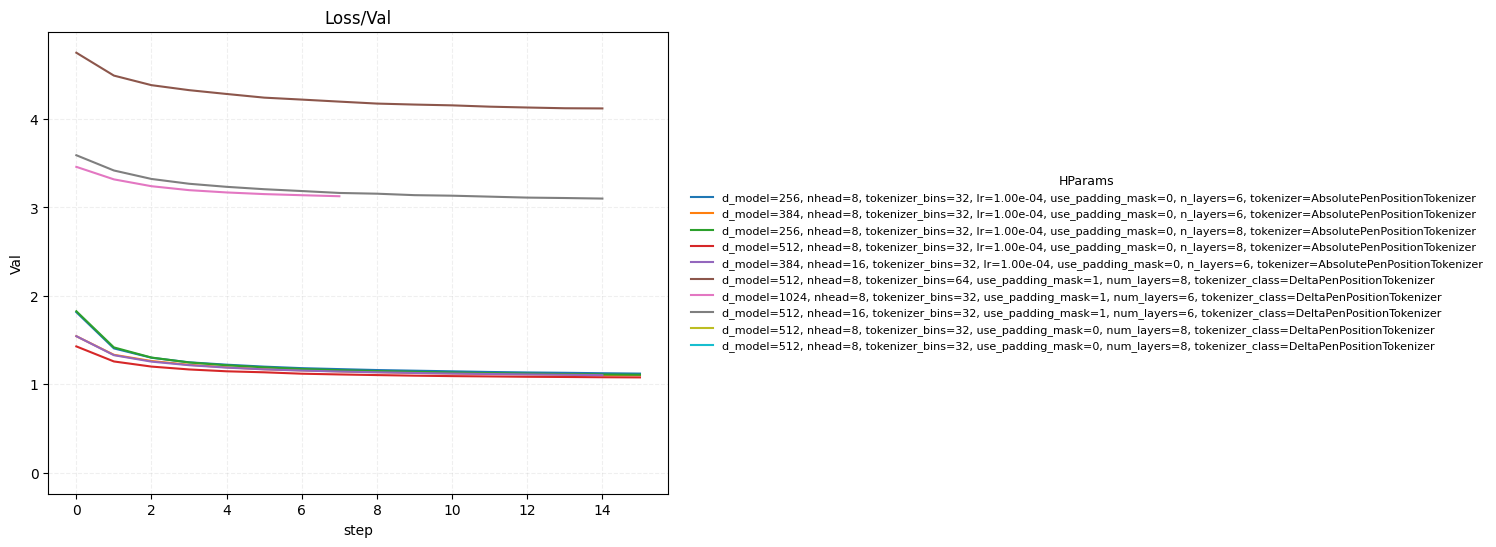

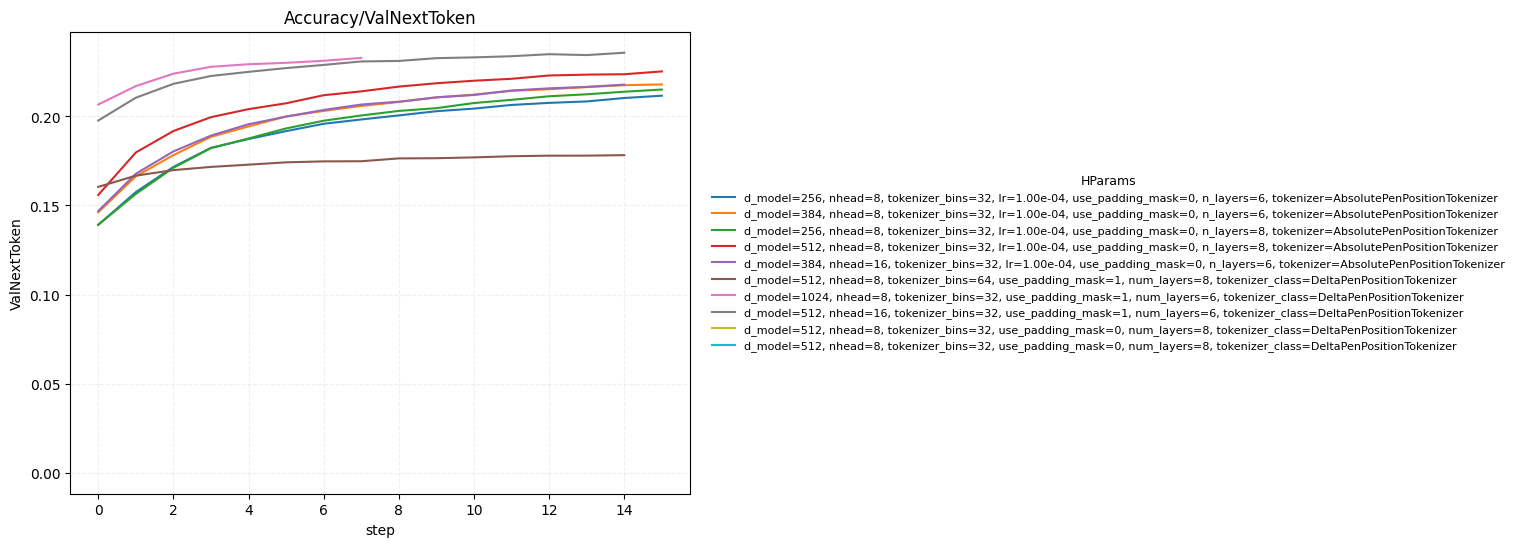

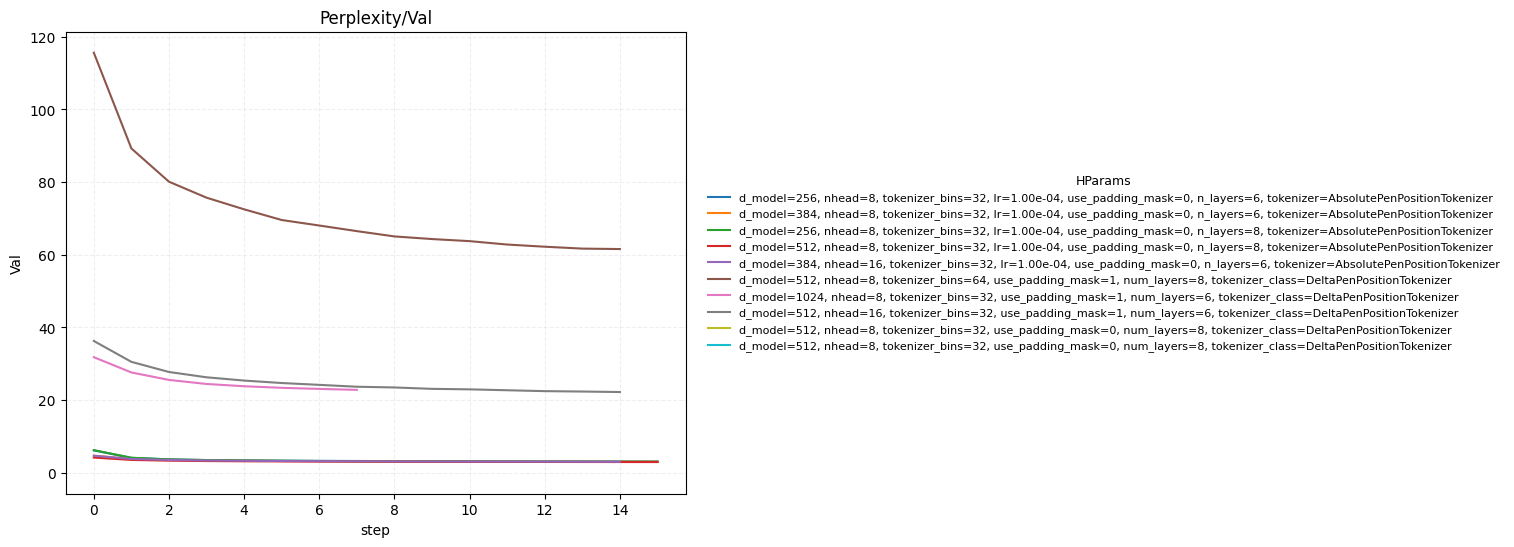

In [10]:
tags = [
    "Loss/Train",
    "Loss/Val",
    "Accuracy/ValNextToken",
    "Perplexity/Val",
]

root = Path("logs_old")

# Map each run (by directory) -> event file(s)
# We'll pick the newest tfevents in each run directory.
runs = defaultdict(list)
for ev in find_event_files(root):
    runs[ev.parent].append(ev)

# Prepare plots, one figure per tag
plots = {}
for tag in tags:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca()
    ax.set_title(tag)
    ax.set_xlabel("step")
    ax.set_ylabel(tag.split("/")[-1])
    plots[tag] = (fig, ax)

for run_dir, ev_files in sorted(runs.items()):
    legend_label = None

    for ev_file in ev_files:
        hparams = parse_hparams_from_eventfile(ev_file)
        legend_label = format_hparams(hparams)
        if legend_label != None:
            break

    # Only display logs where format_hparams is not unknown
    if legend_label is None:
        continue

    scalars = load_scalars(run_dir, set(tags))

    for tag in tags:
        if tag not in scalars:
            continue
        steps, vals = scalars[tag]
        _, ax = plots[tag]
        ax.plot(steps, vals, label=legend_label)

for tag in tags:
    fig, ax = plots[tag]
    ax.grid(True, linestyle="--", alpha=0.2)
    # Move legend outside, shrink text, and add a title

    ax.legend(
        title="HParams",
        fontsize=8,
        title_fontsize=9,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
    )
    fig.tight_layout(rect=[0, 0, 0.8, 1])

plt.show()